# Plot R2, Profile, Cross-section

Values were computed with the python files in `pcmasking.offline_evaluation`

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os

In [3]:
module_path = os.path.abspath(os.path.join('..'))
# Relative imports
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
import gc
import pickle
import pandas as pd
import numpy as np
import copy
from pathlib import Path

In [5]:
from pcmasking.utils.setup import SetupDiagnostics
from pcmasking.neural_networks.load_models import load_models, get_save_plot_folder, load_single_model
from pcmasking.neural_networks.model_diagnostics import ModelDiagnostics
from pcmasking.utils.utils import read_ancilaries, find_closest_value, find_closest_longitude  
from pcmasking.utils.variable import Variable_Lev_Metadata
from pcmasking.neural_networks.cbrain.cam_constants import *

2024-09-19 13:38:20.845600: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [6]:
import matplotlib.transforms as mtransforms
import matplotlib.pyplot as plt
import cmocean
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [7]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [8]:
font_size = 11

In [9]:
plt.rcParams["font.size"] = font_size
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Computer Modern"] + plt.rcParams["font.serif"]
plt.rcParams["mathtext.default"] = "regular"

In [10]:
PROJECT_ROOT = Path.cwd().parent.resolve()

training_run = "training_91_mask_net_prediction_thresholds_spars0.001"
base_dir = os.path.join(PROJECT_ROOT, "output", training_run)
plots_dir = os.path.join(base_dir, "plots_offline_evaluation")
outputs_list_file = os.path.join(base_dir, "outputs_list.txt")

if "prediction_thresholds" in base_dir:
    train_val = "_train"
else: 
    train_val = ""

cfg = os.path.join(base_dir, "cfg_mask_net.yml")

output_dir = os.path.join(base_dir, "plots_offline_evaluation", "plots_paper" + train_val)
Path(output_dir).mkdir(parents=True, exist_ok=True)

ANCIL_FILE = os.path.join(Path.cwd().parent.resolve(), "data", "ancil_spcam.nc")

In [11]:
def load_pickle(f_name):
    with open(f_name, "rb") as f:
        values = pickle.load(f)
    return values

In [12]:
def parse_txt_to_list(txt_file):
    line_list = list()
    with open(txt_file, 'r') as f:
        for line in f:
            line_list.append(line.rstrip())
    return line_list

In [13]:
def save_figures(file_name):
    for format in save_formats:        
        f_path = os.path.join(output_dir, f"{variable}_{file_name}.{format}")

        fig.savefig(f_path, format=format, bbox_inches="tight", transparent=True)
    
        print(f"\nSaved figure {f_path}")


In [14]:
causal_plot_dir = os.path.join(PROJECT_ROOT, "output", "eval_nando", "causal_single_nn", 
                          "models_arch-rasp_thrs-opt-mse6", "plots_offline_evaluation")


In [15]:
variable = "tphystnd" # tphystnd, phq 
stats = "r2"

In [16]:
save_formats = ["pdf", "svg"]

## Plot Profiles

### Load Data

In [17]:
profile_dir = os.path.join(plots_dir, "plots_profiles" + train_val, f"range-1440_lats-90_90_lons0.0_359.0_stats-{stats}")
causal_profile_dir = os.path.join(causal_plot_dir, "plots_profiles", f"range-1440_lats-90_90_lons0.0_359.0_stats-{stats}")

In [18]:
profiles = dict()

profiles["truth"] = load_pickle(os.path.join(profile_dir, f"{variable}_profile_truth.p"))
profiles["pred"] = load_pickle(os.path.join(profile_dir, f"{variable}_profile_pred.p"))
profiles[stats] = load_pickle(os.path.join(profile_dir, f"{variable}_stats-{stats}.p"))

In [19]:
causal_profiles = dict()

causal_profiles["truth"] = load_pickle(os.path.join(causal_profile_dir, f"{variable}_profile_truth.p"))
causal_profiles["pred"] = load_pickle(os.path.join(causal_profile_dir, f"{variable}_profile_pred.p"))
causal_profiles[stats] = load_pickle(os.path.join(causal_profile_dir, f"{variable}_stats-{stats}.p"))

In [20]:
outputs_list = parse_txt_to_list(outputs_list_file)

### Plot Profile with R2

In [21]:

def plot_profile_r2(ax1): 
    blue = '#3b4cc0' #"#1E88E5"
    red = '#b40426' #"#D81B60"

    units = {"tphystnd": r"$K/s$", "phq": r"$kg/(kg \cdot s)$"}
    var_label = {"tphystnd": r"$\Delta T_{phy}$", "phq": r"$\Delta q_{phy}$"}

    vmin = np.min([np.min(profiles["pred"]), np.min(profiles["truth"])])
    vmax = np.max([np.max(profiles["pred"]), np.max(profiles["truth"])])
    vlim = np.max([np.abs(vmin), np.abs(vmax)]) / 2.
    vmin = -vlim;
    vmax = vlim
    
    # Plotting on the primary X-axis (bottom)
    arr_truth = np.mean(profiles["truth"], axis=0)
    arr_pred = np.mean(profiles["pred"], axis=0)
    arr_causal_pred = np.mean(causal_profiles["pred"], axis=0)

    # negative phq values will be cut off
    # last_neg_index = np.where(arr< 0)[0][-1]
    # last_neg_index -= 1
    last_neg_index = 10
    if variable == "phq": 
        line_truth, = ax1.plot(arr_truth[last_neg_index + 1:], 
                               P[last_neg_index + 1:], label="SPCAM", color=blue)
        line_pred, = ax1.plot(arr_pred[last_neg_index + 1:], 
                              P[last_neg_index + 1:], label="Prediction PCM", linestyle="dashed", color=blue)
        line_pred_causal, = ax1.plot(arr_causal_pred[last_neg_index + 1:], 
                                     P[last_neg_index + 1:], label="Prediction CI-NN", linestyle="dotted", color=blue)
    
    else: 
        line_truth, = ax1.plot(arr_truth, P, label="SPCAM", color=blue)
        line_pred, = ax1.plot(arr_pred, P, label="Prediction PCM", linestyle="dashed", color=blue)
        line_pred_causal, = ax1.plot(arr_causal_pred, P, label="Prediction CI-NN", linestyle="dotted", color=blue)

    ax1.set_xlim(vmin, vmax)
    ax1.set_ylim(P[0], P[-1])

    ax1.tick_params(bottom=True, left=True, length=2)
    ax1.tick_params(axis='x', labelsize=font_size)
    ax1.tick_params(axis='y', labelsize=font_size)


    ax1.set_yticks([200, 400, 600, 800])
    
    ax1.set_xlabel(f'{var_label[variable]} ({units[variable]})', color=blue)
    ax1.tick_params(axis='x', colors=blue) 
    
    ax1.set_ylabel('Pressure (hPa)')
  
    
    # Invert the Y-axis
    ax1.invert_yaxis()
    
    # Set the Y-axis labels
    # ax1.set_yticks([1000, 600, 300, 0])
    
    # Create a secondary X-axis (top)
    ax2 = ax1.twiny()  # Share the same Y-axis

    arr = np.mean(profiles[stats], axis=1)
    arr_causal = np.mean(causal_profiles[stats], axis=1)

    if variable == "phq":     
        print(f"Last negative index: {last_neg_index} ({outputs_list[30 + last_neg_index]})")
        print(f"Start plot from index {last_neg_index + 1} ({outputs_list[30 + last_neg_index +1]})")

        line_r2, = ax2.plot(arr[last_neg_index+1:], P[last_neg_index + 1:], label=r"$R^2$ PCM", color=red)  
        line_r2_causal, = ax2.plot(arr_causal[last_neg_index+1:], P[last_neg_index + 1:], label=r"$R^2$ CI-NN",
                                   linestyle="dotted", color=red)  
    else:     
        line_r2, = ax2.plot(arr, P, label=r"$R^2$ PCM", color=red)  
        line_r2_causal, = ax2.plot(arr_causal, P, label=r"$R^2$ CI-NN",linestyle="dotted", color=red)  
    
    ax2.set_xlim(-0.05, 1.05)
    ax2.set_xlabel(r'$R^2$ Score', color=red)
    ax2.tick_params(axis='x', colors=red)  # Set color of ticks and labels to red
    
    ax2.spines['top'].set_color(red)  
    ax2.spines['bottom'].set_color(blue)
    
    ax1.set_rasterized(True)
    ax2.set_rasterized(True)

    if variable == "phq":
        loc = "upper left"
    else: 
        loc = "center left"
    
    plt.legend(handles=[line_truth, line_pred, line_pred_causal, line_r2, line_r2_causal], 
               prop={'size': 11}, loc=loc)



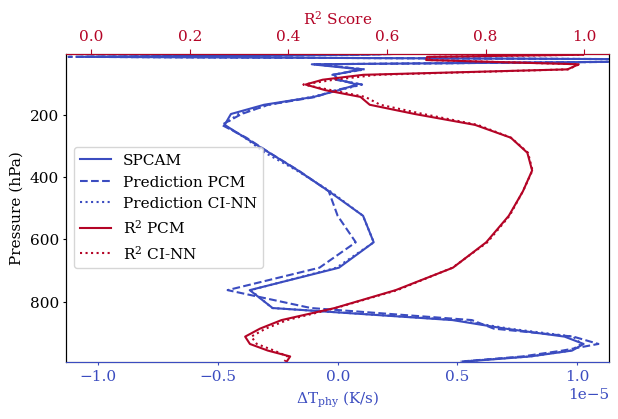

In [22]:
plt.close()

fig, ax1 = plt.subplots(figsize=(7, 4))
plot_profile_r2(ax1)

if variable == "phq":
    f_name = "profile_r2_cutoff_168"
else: 
    f_name = "profile_r2"

# save_figures(f_name)

plt.show()

### Plot Profile/R2 Separately

In [23]:

def plot_profile_only_prediction(ax): 
    blue = '#3b4cc0' #"#1E88E5"
    red = '#b40426' #"#D81B60"

    units = {"tphystnd": r"$K/s$", "phq": r"$kg/(kg \cdot s)$"}
    var_label = {"tphystnd": r"$\Delta T_{phy}$", "phq": r"$\Delta q_{phy}$"}

    vmin = np.min([np.min(profiles["pred"]), np.min(profiles["truth"])])
    vmax = np.max([np.max(profiles["pred"]), np.max(profiles["truth"])])
    vlim = np.max([np.abs(vmin), np.abs(vmax)]) / 2.
    vmin = -vlim;
    vmax = vlim
    
    # Plotting on the primary X-axis (bottom)
    arr_truth = np.mean(profiles["truth"], axis=0)
    arr_pred = np.mean(profiles["pred"], axis=0)
    arr_causal_pred = np.mean(causal_profiles["pred"], axis=0)

    last_neg_index = 10
    if variable == "phq": 
        line_truth, = ax.plot(arr_truth[last_neg_index + 1:], 
                               P[last_neg_index + 1:], label="SPCAM", color=blue)
        line_pred, = ax.plot(arr_pred[last_neg_index + 1:], 
                              P[last_neg_index + 1:], label="Prediction PCM", linestyle="dashed", color=blue)
        line_pred_causal, = ax.plot(arr_causal_pred[last_neg_index + 1:], 
                                     P[last_neg_index + 1:], label="Prediction CI-NN", linestyle="dotted", color=blue)
    
    else: 
        line_truth, = ax.plot(arr_truth, P, label="SPCAM", color=blue)
        line_pred, = ax.plot(arr_pred, P, label="Prediction PCM", linestyle="dashed", color=blue)
        line_pred_causal, = ax1.plot(arr_causal_pred, P, label="Prediction CI-NN", linestyle="dotted", color=blue)

    ax.set_xlim(vmin, vmax)
    ax.set_ylim(P[0], P[-1])

    ax.tick_params(bottom=True, left=True, length=2)
    ax.tick_params(axis='x', labelsize=font_size)
    ax.tick_params(axis='y', labelsize=font_size)


    ax.set_yticks([200, 400, 600, 800])
    
    ax.set_xlabel(f'{var_label[variable]} ({units[variable]})', color='k')
    
    ax.set_ylabel('Pressure (hPa)')
  
    
    # Invert the Y-axis
    ax.invert_yaxis()
    
    # Set the Y-axis labels
    ax.set_rasterized(True)

    if variable == "phq":
        loc = "upper right"
    else: 
        loc = "upper right"
    
    plt.legend(handles=[line_truth, line_pred, line_pred_causal], 
               prop={'size': 10}, loc=loc)



In [24]:
def plot_profile_only_r2(ax): 
    blue = '#3b4cc0' #"#1E88E5"
    red = '#b40426' #"#D81B60"

    units = {"tphystnd": r"$K/s$", "phq": r"$kg/(kg \cdot s)$"}
    var_label = {"tphystnd": r"$\Delta T_{phy}$", "phq": r"$\Delta q_{phy}$"}

    vmin = np.min([np.min(profiles["pred"]), np.min(profiles["truth"])])
    vmax = np.max([np.max(profiles["pred"]), np.max(profiles["truth"])])
    vlim = np.max([np.abs(vmin), np.abs(vmax)]) / 2.
    vmin = -vlim;
    vmax = vlim
    
    # Plotting on the primary X-axis (bottom)
    arr_truth = np.mean(profiles["truth"], axis=0)
    arr_pred = np.mean(profiles["pred"], axis=0)
    arr_causal_pred = np.mean(causal_profiles["pred"], axis=0)

    arr = np.mean(profiles[stats], axis=1)
    arr_causal = np.mean(causal_profiles[stats], axis=1)
    
    last_neg_index = 10
    if variable == "phq": 
        # last_neg_index = np.where(arr< 0)[0][-1]
        # last_neg_index -= 1
    
        print(f"Last negative index: {last_neg_index} ({outputs_list[30 + last_neg_index]})")
        print(f"Start plot from index {last_neg_index + 1} ({outputs_list[30 + last_neg_index +1]})")

        line_r2, = ax.plot(arr[last_neg_index+1:], P[last_neg_index + 1:], label=r"$R^2$ PCM", color=red)  
        line_r2_causal, = ax.plot(arr_causal[last_neg_index+1:], P[last_neg_index + 1:], label=r"$R^2$ CI-NN",
                                   linestyle="dotted", color=red)  
    else:     
        line_r2, = ax.plot(arr, P, label=r"$R^2$ PCM", color=red)  
        line_r2_causal, = ax.plot(arr_causal, P, label=r"$R^2$ CI-NN",linestyle="dotted", color=red)  
    
    ax.tick_params(bottom=True, left=True, length=2)
    ax.tick_params(axis='y', labelsize=font_size)
    
    ax.set_ylim(P[0], P[-1])

    ax.set_yticks([200, 400, 600, 800])
    ax.set_ylabel('Pressure (hPa)')
    # Invert the Y-axis
    ax.invert_yaxis()
    
    ax.set_xlabel(f'{var_label[variable]} ({units[variable]})', color='k')
    
    ax.set_xlim(-0.05, 1.05)
    ax.set_xlabel(r'$R^2$ Score', color='k')


    ax.set_rasterized(True)

    if variable == "phq":
        loc = "upper left"
    else: 
        loc = "upper left"
    
    plt.legend(handles=[line_r2, line_r2_causal], 
               prop={'size': 10}, loc=loc)


Saved figure /p/scratch/icon-a-ml/kuehbacher1/output/training_91_mask_net_prediction_thresholds_spars0.001/plots_offline_evaluation/plots_paper_train/tphystnd_profile_pred_only.pdf

Saved figure /p/scratch/icon-a-ml/kuehbacher1/output/training_91_mask_net_prediction_thresholds_spars0.001/plots_offline_evaluation/plots_paper_train/tphystnd_profile_pred_only.svg


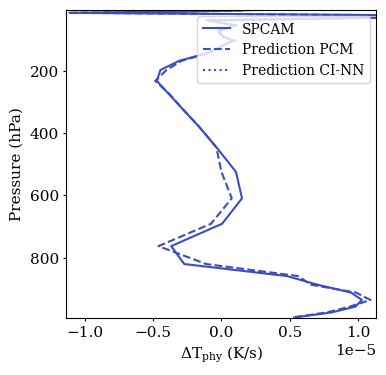

In [25]:
plt.close()

fig, ax = plt.subplots(figsize=(4, 4))
plot_profile_only_prediction(ax)

if variable == "phq":
    f_name = "profile_pred_only_cutoff_168"
else: 
    f_name = "profile_pred_only"

save_figures(f_name)



Saved figure /p/scratch/icon-a-ml/kuehbacher1/output/training_91_mask_net_prediction_thresholds_spars0.001/plots_offline_evaluation/plots_paper_train/tphystnd_profile_r2_only.pdf

Saved figure /p/scratch/icon-a-ml/kuehbacher1/output/training_91_mask_net_prediction_thresholds_spars0.001/plots_offline_evaluation/plots_paper_train/tphystnd_profile_r2_only.svg


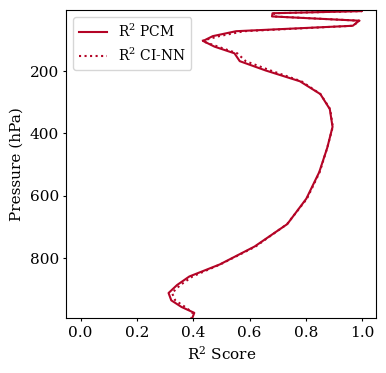

In [26]:
plt.close()

fig, ax = plt.subplots(figsize=(4, 4))
plot_profile_only_r2(ax)

if variable == "phq":
    f_name = "profile_r2_only_cutoff_168"
else: 
    f_name = "profile_r2_only"

save_figures(f_name)


## Plot Profile/R2 Separately in one Figure

In [27]:
def plot_profile_r2_split(ax1, ax2): 
    blue = '#3b4cc0' #"#1E88E5"
    red = '#b40426' #"#D81B60"

    units = {"tphystnd": r"$K/s$", "phq": r"$kg/(kg \cdot s)$"}
    var_label = {"tphystnd": r"$\Delta T_{phy}$", "phq": r"$\Delta q_{phy}$"}

    vmin = np.min([np.min(profiles["pred"]), np.min(profiles["truth"])])
    vmax = np.max([np.max(profiles["pred"]), np.max(profiles["truth"])])
    vlim = np.max([np.abs(vmin), np.abs(vmax)]) / 2.
    vmin = -vlim;
    vmax = vlim
    
    # Plotting on the primary X-axis (bottom)
    arr_truth = np.mean(profiles["truth"], axis=0)
    arr_pred = np.mean(profiles["pred"], axis=0)
    arr_causal_pred = np.mean(causal_profiles["pred"], axis=0)

    # last_neg_index = np.where(arr< 0)[0][-1]
    # last_neg_index -= 1
    last_neg_index = 10
    if variable == "phq": 
        line_truth, = ax1.plot(arr_truth[last_neg_index + 1:], 
                               P[last_neg_index + 1:], label="SPCAM", color=blue)
        line_pred, = ax1.plot(arr_pred[last_neg_index + 1:], 
                              P[last_neg_index + 1:], label="PCM", linestyle="dashed", color=blue)
        line_pred_causal, = ax1.plot(arr_causal_pred[last_neg_index + 1:], 
                                     P[last_neg_index + 1:], label="CI-NN", linestyle="dotted", color=blue)
    
    else: 
        line_truth, = ax1.plot(arr_truth, P, label="SPCAM", color=blue)
        line_pred, = ax1.plot(arr_pred, P, label="PCM", linestyle="dashed", color=blue)
        line_pred_causal, = ax1.plot(arr_causal_pred, P, label="CI-NN", linestyle="dotted", color=blue)

    ax1.set_xlim(vmin, vmax)
    ax1.set_ylim(P[0], P[-1])

    ax1.tick_params(bottom=True, left=True, length=2)
    ax1.set_yticks([200, 400, 600, 800])
    ax1.tick_params(axis='x', labelsize=10)
    ax1.tick_params(axis='y', labelsize=10)
    
    ax1.set_xlabel(f'{var_label[variable]} ({units[variable]})', color='k')
    ax1.set_ylabel('Pressure (hPa)')
  
    
    # Invert the Y-axis
    ax1.invert_yaxis()
    
    # Set the Y-axis labels
    # ax1.set_yticks([1000, 600, 300, 0])
    

    arr = np.mean(profiles[stats], axis=1)
    arr_causal = np.mean(causal_profiles[stats], axis=1)

    if variable == "phq":    
        print(f"Last negative index: {last_neg_index} ({outputs_list[30 + last_neg_index]})")
        print(f"Start plot from index {last_neg_index + 1} ({outputs_list[30 + last_neg_index +1]})")

        line_r2, = ax2.plot(arr[last_neg_index+1:], P[last_neg_index + 1:], label=r"$R^2$ PCM", color=red)  
        line_r2_causal, = ax2.plot(arr_causal[last_neg_index+1:], P[last_neg_index + 1:], label=r"$R^2$ CI-NN",
                                   linestyle="dotted", color=red)  
    else:     
        line_r2, = ax2.plot(arr, P, label=r"$R^2$ PCM", color=red)  
        line_r2_causal, = ax2.plot(arr_causal, P, label=r"$R^2$ CI-NN",linestyle="dotted", color=red)  
    
    ax2.set_xlim(-0.05, 1.05)
    ax2.set_xlabel(r'$R^2$ Score', color='k')
    ax2.tick_params(axis='x', labelsize=10)
    

    ax1.set_rasterized(True)
    ax2.set_rasterized(True)

    if variable == "phq":
        loc1 = "upper right"
        loc2 = "upper left"
    else: 
        loc1 = "upper right"
        loc2 = "upper left"

    ax1.legend(loc=loc1, prop={'size': 10}, fancybox=True)
    ax2.legend(loc=loc2, prop={'size': 10}, fancybox=True)




Saved figure /p/scratch/icon-a-ml/kuehbacher1/output/training_91_mask_net_prediction_thresholds_spars0.001/plots_offline_evaluation/plots_paper_train/tphystnd_profile_pred_r2_split.pdf

Saved figure /p/scratch/icon-a-ml/kuehbacher1/output/training_91_mask_net_prediction_thresholds_spars0.001/plots_offline_evaluation/plots_paper_train/tphystnd_profile_pred_r2_split.svg


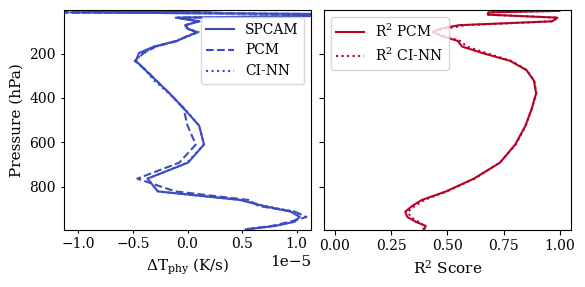

In [28]:
plt.close()

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(6, 3))

plot_profile_r2_split(ax1, ax2)

if variable == "phq":
    f_name = "profile_r2_cutoff_168"
else: 
    f_name = "profile_r2"

fig.tight_layout()
# Add some space between the subplots
fig.subplots_adjust(wspace=0.05)

if variable == "phq":
    f_name = "profile_pred_r2_split_cutoff_168"
else: 
    f_name = "profile_pred_r2_split"

save_figures(f_name)

## Plot Cross-sections

### Load Data

In [29]:
cross_section_dir = os.path.join(plots_dir, "plots_cross_section" + train_val, f"mean-all_stats-{stats}_no_diff")

In [30]:
cross_sections = dict()

cross_sections["truth"] = load_pickle(os.path.join(cross_section_dir, f"{variable}_cross_section_truth.p"))
cross_sections["pred"] = load_pickle(os.path.join(cross_section_dir, f"{variable}_cross_section_pred.p"))
cross_sections[stats] = load_pickle(os.path.join(cross_section_dir, f"{variable}_cross_section_stats-{stats}.p"))

### Plot Cross-sections Truth/Prediction

In [31]:

def plot_cross_section(ax, truth_or_pred, v_name, set_title=True, snap_shot=False):
    
    vmin = np.min([np.min(cross_sections["pred"]), np.min(cross_sections["truth"])])
    vmax = np.max([np.max(cross_sections["pred"]), np.max(cross_sections["truth"])])
    
    vlim = np.max([np.abs(vmin), np.abs(vmax)]) / 2.
    vmin = -vlim;
    vmax = vlim
    
    extend = None
    
    cThemes = {'tphystnd': 'RdBu_r', 'phq': 'RdBu_r'}
    cmap = cThemes[v_name]

    levels, latitudes, longitudes = read_ancilaries(Path(ANCIL_FILE))

    I = ax.pcolormesh(latitudes, P, cross_sections[truth_or_pred], vmin=vmin, vmax=vmax, cmap=cmap)
    ax.invert_yaxis()

    ax.tick_params(bottom=True, left=True, length=2)
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)

    ax.set_xticks([-90, -60, -30, 0, 30, 60, 90])
    ax.set_xticklabels([r"$-90^{\circ}$S",  r"$-60^{\circ}$S", r"$-30^{\circ}$S", r"EQ.", 
                        r"$30^{\circ}$N", r"$60^{\circ}$N", r"$90^{\circ}$N"])
    ax.set_xlabel('Latitude')

    ax.set_yticks([200, 400, 600, 800])
    ax.set_ylabel('Pressure (hPa)')

    var_label = {"tphystnd": r"$\Delta T_{phy}$", "phq": r"$\Delta q_{phy}$"}
    units = {"tphystnd": r"$K/s$", "phq": r"$kg/(kg \cdot s)$"}
    
    cax = fig.add_axes([ax.get_position().x0, ax.get_position().y0 - 0.22, # 0.16
                        ax.get_position().width,  0.03])
    cb = fig.colorbar(I, cax=cax, orientation='horizontal', extend=extend)
    cb.set_label(f"{var_label[variable]} ({units[variable]})")


    if set_title:
        if truth_or_pred == "truth":
            if snap_shot: 
                ax.set_title(f"SPCAM Truth {var_label[variable]}", fontsize=font_size) 
            else: 
                ax.set_title(f"SPCAM Truth", fontsize=font_size)
        else: 
            if snap_shot: 
                ax.set_title(f"PCMasking Prediction {var_label[variable]}", fontsize=font_size) 
            else: 
                ax.set_title(f"PCMasking Prediction", fontsize=font_size) 

    ax.set_rasterized(True)
    


Saved figure /p/scratch/icon-a-ml/kuehbacher1/output/training_91_mask_net_prediction_thresholds_spars0.001/plots_offline_evaluation/plots_paper_train/tphystnd_cross_section_pred.pdf

Saved figure /p/scratch/icon-a-ml/kuehbacher1/output/training_91_mask_net_prediction_thresholds_spars0.001/plots_offline_evaluation/plots_paper_train/tphystnd_cross_section_pred.svg


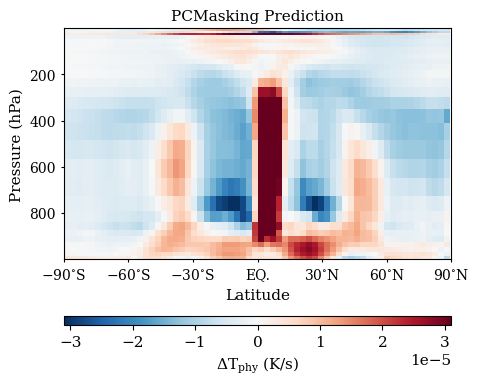

In [32]:
plt.close()
fig, ax = plt.subplots(figsize=(5, 3))

plot_cross_section(ax, "pred", variable)

save_figures("cross_section_pred")

plt.show()


Saved figure /p/scratch/icon-a-ml/kuehbacher1/output/training_91_mask_net_prediction_thresholds_spars0.001/plots_offline_evaluation/plots_paper_train/tphystnd_cross_section_truth.pdf

Saved figure /p/scratch/icon-a-ml/kuehbacher1/output/training_91_mask_net_prediction_thresholds_spars0.001/plots_offline_evaluation/plots_paper_train/tphystnd_cross_section_truth.svg


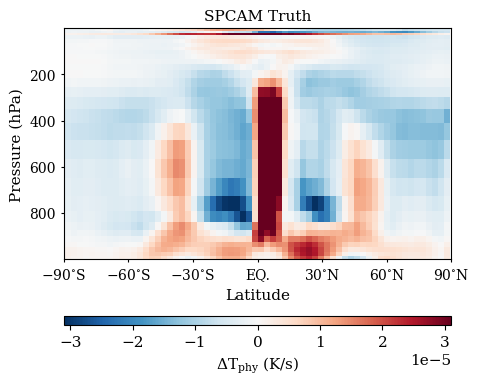

In [33]:
plt.close()
fig, ax = plt.subplots(figsize=(5, 3))

plot_cross_section(ax, "truth", variable)

save_figures("cross_section_truth")

plt.show()

### Plot Cross-section R2

In [34]:

def plot_cross_section_r2(ax, set_title=True):
    vmin = 0.;
    vmax = 1.
    extend = 'min'
    cmap = 'Reds'

    stats_plot = copy.deepcopy(cross_sections[stats])

    if variable == "phq": 
        last_neg_index = 10
        # last_neg_index -= 1
    
        print(f"Last negative index: {last_neg_index} ({outputs_list[30 + last_neg_index]})")

        stats_plot[0:last_neg_index + 1, :,] = -np.inf

    levels, latitudes, longitudes = read_ancilaries(Path(ANCIL_FILE))

    
    I = ax.pcolormesh(latitudes, P, stats_plot, vmin=vmin, vmax=vmax, cmap=cmap)
    ax.invert_yaxis()

    ax.tick_params(bottom=True, left=True, length=2)
    ax.tick_params(axis='x', labelsize=font_size)
    ax.tick_params(axis='y', labelsize=font_size)

    ax.set_xticks([-90, -60, -30, 0, 30, 60, 90])
    ax.set_xticklabels([r"$-90^{\circ}$S",  r"$-60^{\circ}$S", r"$-30^{\circ}$S", r"EQ.", 
                        r"$30^{\circ}$N", r"$60^{\circ}$N", r"$90^{\circ}$N"])
    ax.set_xlabel('Latitude')

    ax.set_yticks([200, 400, 600, 800])
    ax.set_ylabel('Pressure (hPa)')


    cax = fig.add_axes([ax.get_position().x0, ax.get_position().y0 - 0.22,
                        ax.get_position().width,  0.03])
    cb = fig.colorbar(I, cax=cax, orientation='horizontal', extend=extend)    

    if set_title:
        ax.set_title(r"$R^{2}$ Score", fontsize=font_size)

    ax.set_rasterized(True)
   


Saved figure /p/scratch/icon-a-ml/kuehbacher1/output/training_91_mask_net_prediction_thresholds_spars0.001/plots_offline_evaluation/plots_paper_train/tphystnd_cross_section_r2.pdf

Saved figure /p/scratch/icon-a-ml/kuehbacher1/output/training_91_mask_net_prediction_thresholds_spars0.001/plots_offline_evaluation/plots_paper_train/tphystnd_cross_section_r2.svg


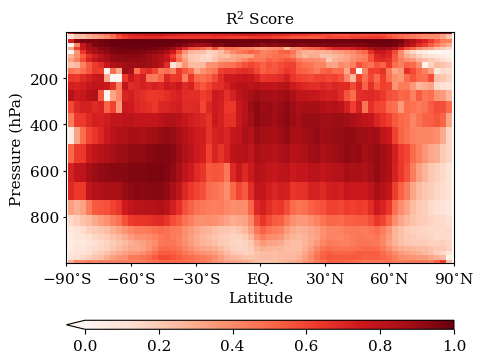

In [35]:
plt.close()
fig, ax = plt.subplots(figsize=(5, 3))
plot_cross_section_r2(ax)

if variable == "phq":
    f_name = "cross_section_r2_cutoff_168"
else: 
    f_name = "cross_section_r2"

save_figures(f_name)
 
plt.show()

### Plot Cross-section Truth/Prediction and R2 

In [36]:
def plot_cross_sections_and_r2(axes, v_name, set_title=True):

    labelsize = 10
    
    vmin = np.min([np.min(cross_sections["pred"]), np.min(cross_sections["truth"])])
    vmax = np.max([np.max(cross_sections["pred"]), np.max(cross_sections["truth"])])
    
    vlim = np.max([np.abs(vmin), np.abs(vmax)]) / 2.
    vmin = -vlim;
    vmax = vlim
        
    cThemes = {'tphystnd': 'RdBu_r', 'phq': 'RdBu_r'}
    cmap = cThemes[v_name]

    levels, latitudes, longitudes = read_ancilaries(Path(ANCIL_FILE))

    # plot truth
    im1 = axes[0].pcolormesh(latitudes, P, cross_sections['truth'], vmin=vmin, vmax=vmax, cmap=cmap)
    axes[0].invert_yaxis()

    axes[0].tick_params(bottom=True, left=True, length=2)
    axes[0].tick_params(axis='x', labelsize=labelsize)
    axes[0].tick_params(axis='y', labelsize=labelsize)

    axes[0].set_xticks([-90, -60, -30, 0, 30, 60, 90])
    axes[0].set_xticklabels([r"$-90^{\circ}$S",  r"$-60^{\circ}$S", r"$-30^{\circ}$S", r"EQ.", 
                        r"$30^{\circ}$N", r"$60^{\circ}$N", r"$90^{\circ}$N"])
    axes[0].set_xlabel('Latitude')

    axes[0].set_yticks([200, 400, 600, 800])
    axes[0].set_ylabel('Pressure (hPa)')

     # plot prediction
    im2 = axes[1].pcolormesh(latitudes, P, cross_sections['pred'], vmin=vmin, vmax=vmax, cmap=cmap)
    axes[1].invert_yaxis()

    axes[1].tick_params(bottom=True, left=True, length=2)
    axes[1].tick_params(axis='x', labelsize=labelsize)

    axes[1].set_xticks([-90, -60, -30, 0, 30, 60, 90])
    axes[1].set_xticklabels([r"$-90^{\circ}$S",  r"$-60^{\circ}$S", r"$-30^{\circ}$S", r"EQ.", 
                        r"$30^{\circ}$N", r"$60^{\circ}$N", r"$90^{\circ}$N"])
    axes[1].set_xlabel('Latitude')


    # Plot R2    
    vmin = 0.;
    vmax = 1.
    cmap = 'Reds'

    stats_plot = copy.deepcopy(cross_sections['r2'])

    if variable == "phq": 
        last_neg_index = 10
        # last_neg_index -= 1
    
        print(f"Last negative index: {last_neg_index} ({outputs_list[30 + last_neg_index]})")

        stats_plot[0:last_neg_index + 1, :,] = -np.inf
        
    im3 = axes[2].pcolormesh(latitudes, P, stats_plot, vmin=vmin, vmax=vmax, cmap=cmap)
    axes[2].invert_yaxis()

    axes[2].tick_params(bottom=True, left=True, length=2)
    axes[2].tick_params(axis='x', labelsize=labelsize)

    axes[2].set_xticks([-90, -60, -30, 0, 30, 60, 90])
    axes[2].set_xticklabels([r"$-90^{\circ}$S",  r"$-60^{\circ}$S", r"$-30^{\circ}$S", r"EQ.", 
                        r"$30^{\circ}$N", r"$60^{\circ}$N", r"$90^{\circ}$N"])
    axes[2].set_xlabel('Latitude')

    # align first and last labels differently
    for ax in axes:
        labels = ax.get_xticklabels()
        if labels:
            for i in [0, 1, 2]: # left of the equator
                offset_value = 0.155 if i == 0 else 0.15
                offset = mtransforms.ScaledTranslation(offset_value, 0, fig.dpi_scale_trans)
                labels[i].set_transform(labels[i].get_transform() + offset)
                
            for i in [4, 5, 6]: # right of the equator
                offset = mtransforms.ScaledTranslation(-0.15, 0, fig.dpi_scale_trans)
                labels[i].set_transform(labels[i].get_transform() + offset)

            # Equator
            offset= mtransforms.ScaledTranslation(0.02, 0, fig.dpi_scale_trans)
            labels[3].set_transform(labels[3].get_transform() + offset)


    # colorbar truth/prediction
    var_label = {"tphystnd": r"$\Delta T_{phy}$", "phq": r"$\Delta q_{phy}$"}
    units = {"tphystnd": r"$K/s$", "phq": r"$kg/(kg \cdot s)$"}
    
    #  (left, bottom, width, height)
    cax = fig.add_axes([axes[0].get_position().x0 + axes[0].get_position().width/2 + 0.03, axes[0].get_position().y0 - 0.22, # 0.16
                        axes[0].get_position().width,  0.03])
    cb = fig.colorbar(im2, cax=cax, orientation='horizontal', extend=None)

    cb.set_label(f"{var_label[variable]} ({units[variable]})")

    # colorbar R2
    #  (left, bottom, width, height)
    cax = fig.add_axes([axes[2].get_position().x0-0.01, axes[2].get_position().y0 - 0.22,
                        axes[2].get_position().width,  0.03])
    cb = fig.colorbar(im3, cax=cax, orientation='horizontal', extend='min')    

    axes[0].set_rasterized(True)
    axes[1].set_rasterized(True)
    axes[2].set_rasterized(True)

           
    if set_title:
        axes[0].set_title(f"SPCAM Truth", fontsize=font_size) 
        axes[1].set_title(f"PCMasking Prediction", fontsize=font_size) 
        axes[2].set_title(r"$R^{2}$ Score", fontsize=font_size)

    


Saved figure /p/scratch/icon-a-ml/kuehbacher1/output/training_91_mask_net_prediction_thresholds_spars0.001/plots_offline_evaluation/plots_paper_train/tphystnd_cross_sections_and_r2.pdf

Saved figure /p/scratch/icon-a-ml/kuehbacher1/output/training_91_mask_net_prediction_thresholds_spars0.001/plots_offline_evaluation/plots_paper_train/tphystnd_cross_sections_and_r2.svg


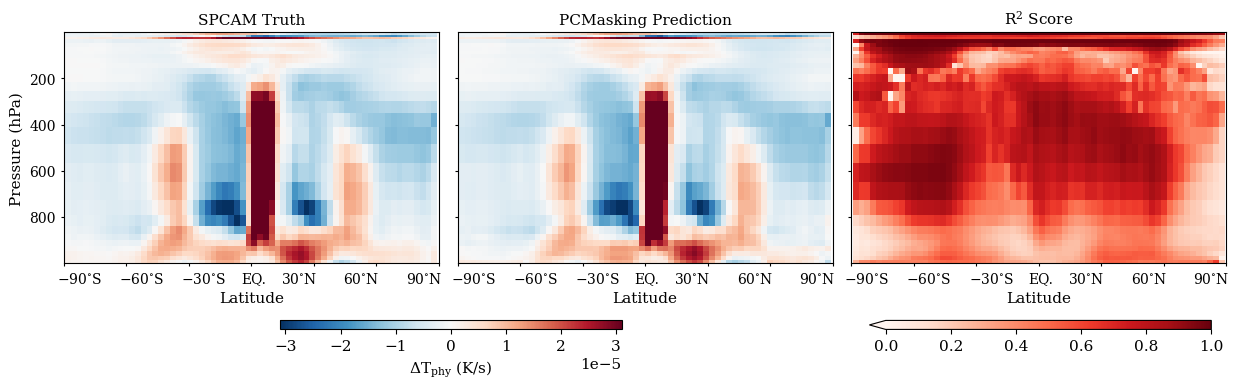

In [37]:
plt.close()

# Create a figure with two subplot|s
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(15, 3))

plot_cross_sections_and_r2(axes, variable)

# Add some space between the subplots
fig.subplots_adjust(wspace=0.05)

if variable == "phq":
    f_name = "cross_sections_and_r2_cutoff_168"
else: 
    f_name = "cross_sections_and_r2"

save_figures(f_name)

## Plot Cross-section Snapshots

In [38]:
step = 500
cross_section_dir = os.path.join(plots_dir, "plots_cross_section" + train_val, f"step-{step}_no_diff")

In [39]:
cross_sections = dict()

cross_sections["truth"] = load_pickle(os.path.join(cross_section_dir, f"{variable}_cross_section_truth.p"))
cross_sections["pred"] = load_pickle(os.path.join(cross_section_dir, f"{variable}_cross_section_pred.p"))

In [40]:
print(output_dir)

/p/scratch/icon-a-ml/kuehbacher1/output/training_91_mask_net_prediction_thresholds_spars0.001/plots_offline_evaluation/plots_paper_train



Saved figure /p/scratch/icon-a-ml/kuehbacher1/output/training_91_mask_net_prediction_thresholds_spars0.001/plots_offline_evaluation/plots_paper_train/tphystnd_cross_section_truth_snap_shot_step_500.pdf

Saved figure /p/scratch/icon-a-ml/kuehbacher1/output/training_91_mask_net_prediction_thresholds_spars0.001/plots_offline_evaluation/plots_paper_train/tphystnd_cross_section_truth_snap_shot_step_500.svg


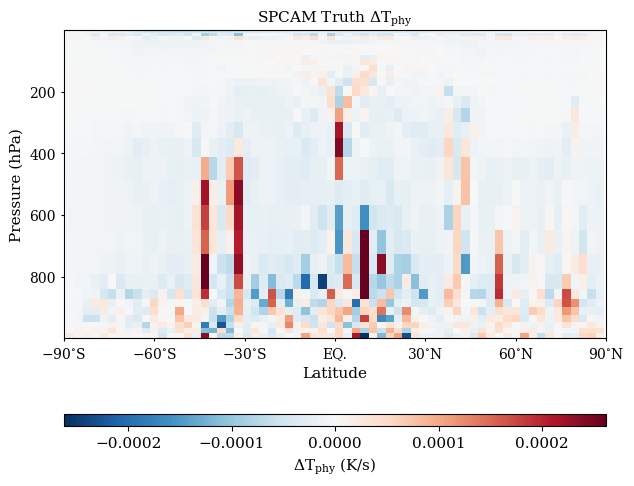

In [41]:
# Create a figure and an axis
plt.close()
fig, ax = plt.subplots(figsize=(7, 4))

plot_cross_section(ax, "truth", variable, snap_shot=True)

f_name = f"cross_section_truth_snap_shot_step_{step}"
save_figures(f_name)



Saved figure /p/scratch/icon-a-ml/kuehbacher1/output/training_91_mask_net_prediction_thresholds_spars0.001/plots_offline_evaluation/plots_paper_train/tphystnd_cross_section_pred_snap_shot_step_500.pdf

Saved figure /p/scratch/icon-a-ml/kuehbacher1/output/training_91_mask_net_prediction_thresholds_spars0.001/plots_offline_evaluation/plots_paper_train/tphystnd_cross_section_pred_snap_shot_step_500.svg


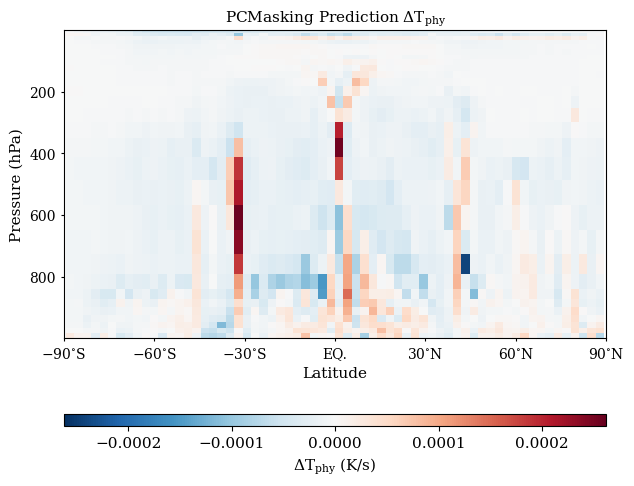

In [42]:
# Create a figure and an axis
plt.close()
fig, ax = plt.subplots(figsize=(7, 4))

plot_cross_section(ax, "pred", variable, snap_shot=True)

f_name = f"cross_section_pred_snap_shot_step_{step}"
save_figures(f_name)
